In [405]:
import psycopg as pg
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from geopy.distance import geodesic
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.cm as cm
from scipy.spatial.distance import cdist, pdist
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from mpl_toolkits.basemap import Basemap
import copy
import json
import math
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')
from datetime import timezone, datetime
import pytz
 
%matplotlib inline

In [680]:
connection = pg.connect(
    host="localhost",
    port="5432",
    dbname="NYCBikes",  # Replace with your actual database
    user="postgres",
    password="postgres"
)


In [681]:
# Query to fetch spatial heatmap data with timestamps
query = """
    SELECT * 
    FROM  station_information  
"""

query1 = """
    SELECT * 
    FROM  station_flow  
"""

dfStInf = pd.read_sql_query(query, connection)
dfStFlow = pd.read_sql_query(query1, connection)

print(f"Finished reading {len(dfStInf)}")
print(f"Finished reading {len(dfStFlow)}")
# Close the connection
connection.close()

Finished reading 2143
Finished reading 3185984


In [672]:
dfStFlow.head()

,station_id,starttime,in_count,out_count
0,2733.03,2024-03-01 00:00:00-05:00,0,0
1,2733.03,2024-03-01 00:30:00-05:00,0,0
2,2733.03,2024-03-01 01:00:00-05:00,0,0
3,2733.03,2024-03-01 01:30:00-05:00,0,0
4,2733.03,2024-03-01 02:00:00-05:00,0,0


In [682]:
dfStInf.head()

,station_id,station_name,station_lat,station_lng,geom
0,2733.03,67 St & Erik Pl,40.635560,-74.012980,0101000020767D0000D1AF58BB573E1241053C582E936C...
1,2782.02,5 Ave & 67 St,40.635679,-74.020005,0101000020767D00005A8D35910E35124157632E993D6E...
2,2821.05,7 Ave & 62 St,40.647379,-74.000911,0101000020767D00009EDD2EC84B4E1241BA8089A79F10...
3,2832.03,4 Ave & Shore Road Dr,40.679279,-73.981540,0101000020767D000090C1C384E267124127B0D2C771CB...
4,2861.02,57 St & 7 Ave,40.675833,-74.014726,0101000020767D0000BC979AC70B3C1241F9F826AF9A9B...


In [683]:
dfStInf = dfStInf.drop('geom', axis=1)

In [684]:
dfStInf.head()

,station_id,station_name,station_lat,station_lng
0,2733.03,67 St & Erik Pl,40.635560,-74.012980
1,2782.02,5 Ave & 67 St,40.635679,-74.020005
2,2821.05,7 Ave & 62 St,40.647379,-74.000911
3,2832.03,4 Ave & Shore Road Dr,40.679279,-73.981540
4,2861.02,57 St & 7 Ave,40.675833,-74.014726


In [685]:
# Convert the time from to another timezone
# The point in time does not change, only the associated timezone
my_timezone = pytz.timezone('America/New_York')
dfStFlow['starttime'] = dfStFlow['starttime'].dt.tz_convert(my_timezone)
dfStFlow.head()

,station_id,starttime,in_count,out_count
0,2733.03,2024-03-01 00:00:00-05:00,0,0
1,2733.03,2024-03-01 00:30:00-05:00,0,0
2,2733.03,2024-03-01 01:00:00-05:00,0,0
3,2733.03,2024-03-01 01:30:00-05:00,0,0
4,2733.03,2024-03-01 02:00:00-05:00,0,0


In [686]:
dfflow = dfStFlow[(dfStFlow['starttime'].dt.month == 3) & (dfStFlow['starttime'].dt.day <= 7)]
dfflow.head()

,station_id,starttime,in_count,out_count
0,2733.03,2024-03-01 00:00:00-05:00,0,0
1,2733.03,2024-03-01 00:30:00-05:00,0,0
2,2733.03,2024-03-01 01:00:00-05:00,0,0
3,2733.03,2024-03-01 01:30:00-05:00,0,0
4,2733.03,2024-03-01 02:00:00-05:00,0,0


In [662]:
df_temp = dfflow.pivot(index='station_id', columns='starttime').reset_index()
df_temp

station_id                  in_count                            \
starttime        NaT 2024-03-01 00:00:00-05:00 2024-03-01 00:30:00-05:00   
0                NaN                         0                         0   
1            2733.03                         0                         0   
2            2782.02                         0                         0   
3            2821.05                         0                         0   
4            2832.03                         0                         0   
...              ...                       ...                       ...   
2139           JC105                         0                         0   
2140           JC109                         0                         0   
2141          SYS016                         0                         1   
2142          SYS033                         0                         0   
2143          SYS038                         0                         0   

                                                               \
starttime 2024-03-01 01:00:00-05:00 2024-03-01 01:30:00-05:00   
0                                 0                         0   
1                                 0                         0   
2                                 0                         0   
3                                 0                         0   
4                                 0                         0   
...                             ...                       ...   
2139                              0                         0   
2140                              0                         0   
2141                              0                         0   
2142                              0                         0   
2143                              0                         0   

                                                               \
starttime 2024-03-01 02:00:00-05:00 2024-03-01 02:30:00-05:00   
0                                 0                         0   
1                                 0                         0   
2                                 0                         0   
3                                 1                         0   
4                                 0                         0   
...                             ...                       ...   
2139                              0                         0   
2140                              0                         0   
2141                              0                         0   
2142                              0                         0   
2143                              0                         0   

                                                               \
starttime 2024-03-01 03:00:00-05:00 2024-03-01 03:30:00-05:00   
0                                 0                         0   
1                                 0                         0   
2                                 0                         0   
3                                 0                         0   
4                                 0                         0   
...                             ...                       ...   
2139                              0                         0   
2140                              0                         0   
2141                              0                         0   
2142                              0                         0   
2143                              0                         0   

                                     ...                 out_count  \
starttime 2024-03-01 04:00:00-05:00  ... 2024-03-07 19:00:00-05:00   
0                                 0  ...                         0   
1                                 0  ...                         0   
2                                 0  ...                         0   
3                                 0  ...                         1   
4                                 0  ...                       

In [663]:
df_temp = df_temp.drop(df_temp.index[0])
df_temp.head()

station_id                  in_count                            \
starttime        NaT 2024-03-01 00:00:00-05:00 2024-03-01 00:30:00-05:00   
1            2733.03                         0                         0   
2            2782.02                         0                         0   
3            2821.05                         0                         0   
4            2832.03                         0                         0   
5            2861.02                         0                         0   

                                                               \
starttime 2024-03-01 01:00:00-05:00 2024-03-01 01:30:00-05:00   
1                                 0                         0   
2                                 0                         0   
3                                 0                         0   
4                                 0                         0   
5                                 0                         0   

                                                               \
starttime 2024-03-01 02:00:00-05:00 2024-03-01 02:30:00-05:00   
1                                 0                         0   
2                                 0                         0   
3                                 1                         0   
4                                 0                         0   
5                                 0                         0   

                                                               \
starttime 2024-03-01 03:00:00-05:00 2024-03-01 03:30:00-05:00   
1                                 0                         0   
2                                 0                         0   
3                                 0                         0   
4                                 0                         0   
5                                 0                         0   

                                     ...                 out_count  \
starttime 2024-03-01 04:00:00-05:00  ... 2024-03-07 19:00:00-05:00   
1                                 0  ...                         0   
2                                 0  ...                         0   
3                                 0  ...                         1   
4                                 0  ...                         0   
5                                 0  ...                         0   

                                                               \
starttime 2024-03-07 19:30:00-05:00 2024-03-07 20:00:00-05:00   
1                                 0                         0   
2                                 0                         0   
3                                 1                         0   
4                                 0                         3   
5                                 0                         0   

                                                               \
starttime 2024-03-07 20:30:00-05:00 2024-03-07 21:00:00-05:00   
1                                 0                         0   
2                                 0                         0   
3                                 0                         0   
4                                 0                         0   
5                                 0                         0   

                                                               \
starttime 2024-03-07 21:30:00-05:00 2024-03-07 22:00:00-05:00   
1                                 0                         0   
2                                 0                         0   
3                                 0                         0   
4                                 0                         0   
5                                 0                         0   

                                                               \
starttime 2024-03-07 22:30:00-05:00 2024-03-07 23:00:00-05:00   
1                                 0                         0   
2                                 0                    

In [687]:
df_All= dfStInf.merge(df_temp.droplevel(1, axis=1), on=['station_id'], how ='left')

In [688]:
df_All

,station_id,station_name,station_lat,station_lng,in_count,in_count,in_count,in_count,in_count,in_count,...,out_count,out_count,out_count,out_count,out_count,out_count,out_count,out_count,out_count,out_count
0,2733.03,67 St & Erik Pl,40.635560,-74.012980,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2782.02,5 Ave & 67 St,40.635679,-74.020005,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2821.05,7 Ave & 62 St,40.647379,-74.000911,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2832.03,4 Ave & Shore Road Dr,40.679279,-73.981540,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2861.02,57 St & 7 Ave,40.675833,-74.014726,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2138,JC105,Hoboken Ave at Monmouth St,40.750604,-74.024020,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2139,JC109,Bergen Ave & Sip Ave,40.725726,-74.071959,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2140,SYS016,Morgan Bike Mechanics,40.701080,-73.917900,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2141,SYS033,Pier 40 X2,40.729170,-73.998102,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [666]:
X = dfStInf[['station_lat', 'station_lng']].values
X

array([[ 40.63556   , -74.01298   ],
       [ 40.635679  , -74.020005  ],
       [ 40.647379  , -74.000911  ],
       ...,
       [ 40.70108   , -73.9179    ],
       [ 40.72917025, -73.99810231],
       [ 40.700119  , -73.9862    ]])

In [420]:
Ks = range(1, 10)
Ks

range(1, 10)

In [432]:
Ks = range(1, 10)
kmean = [KMeans(n_clusters=i).fit(X) for i in Ks]

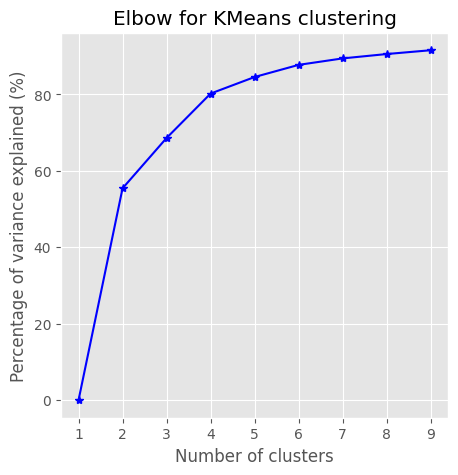

In [438]:
def plot_elbow(kmean, X):
    centroids = [k.cluster_centers_ for k in kmean]
    D_k = [cdist(X, center, 'euclidean') for center in centroids]
    dist = [np.min(D,axis=1) for D in D_k]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(X)**2)/X.shape[0]
    bss = tss-wcss

    plt.subplots(nrows=1, ncols=1, figsize=(5,5))
    ax = plt.subplot(1, 1, 1)
    ax.plot(Ks, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained (%)')
    plt.title('Elbow for KMeans clustering')
    plt.savefig('/Users/avaisman/tmp/PythonNotebooks/Figs/elbow.svg', format="svg", orientation ='landscape',bbox_inches ="tight", edgecolor ='g', dpi=250)
    plt.show()

plot_elbow(kmean, X)

In [439]:
lat = list(dfStInf['station_lat'])


In [440]:
lon = list(dfStInf['station_lng'])


In [431]:
 def plot_stations_map(ax, stns):
    # determine range to print based on min, max lat and lon of the data
    lat = list(stns['station_lat'])
    lon = list(stns['station_lng'])
    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    # create map using BASEMAP
    m = Basemap(llcrnrlon=lon_min,
                llcrnrlat=lat_min,
                urcrnrlon=lon_max,
                urcrnrlat=lat_max,
                lat_0=(lat_max - lat_min)/2,
                lon_0=(lon_max - lon_min)/2,
                projection='lcc',
                resolution = 'f',)

    m.drawcoastlines()
    m.fillcontinents(lake_color='aqua')
    m.drawmapboundary(fill_color='aqua')
    m.drawrivers()    
    
    # plot points
    clist = list(stns['cluster'].unique())
    if -1 in clist:
        clist.remove(-1)
    k = len(clist)
    colors = iter(cm.Set1(np.linspace(0, 1, max(10, k))))
    for i in range(k):
        color = next(colors)
        df = stns.loc[stns['cluster'] == clist[i]]        
        #print("Cluster {} has {} samples.".format(clist[i], df.shape[0]))
        
        # convert lat and lon to map projection coordinates
        lons, lats = m(list(df['station_lng']), list(df['station_lat']))        
        ax.scatter(lons, lats, marker = 'o', color=color, edgecolor='gray', zorder=5, alpha=1.0, s=15)

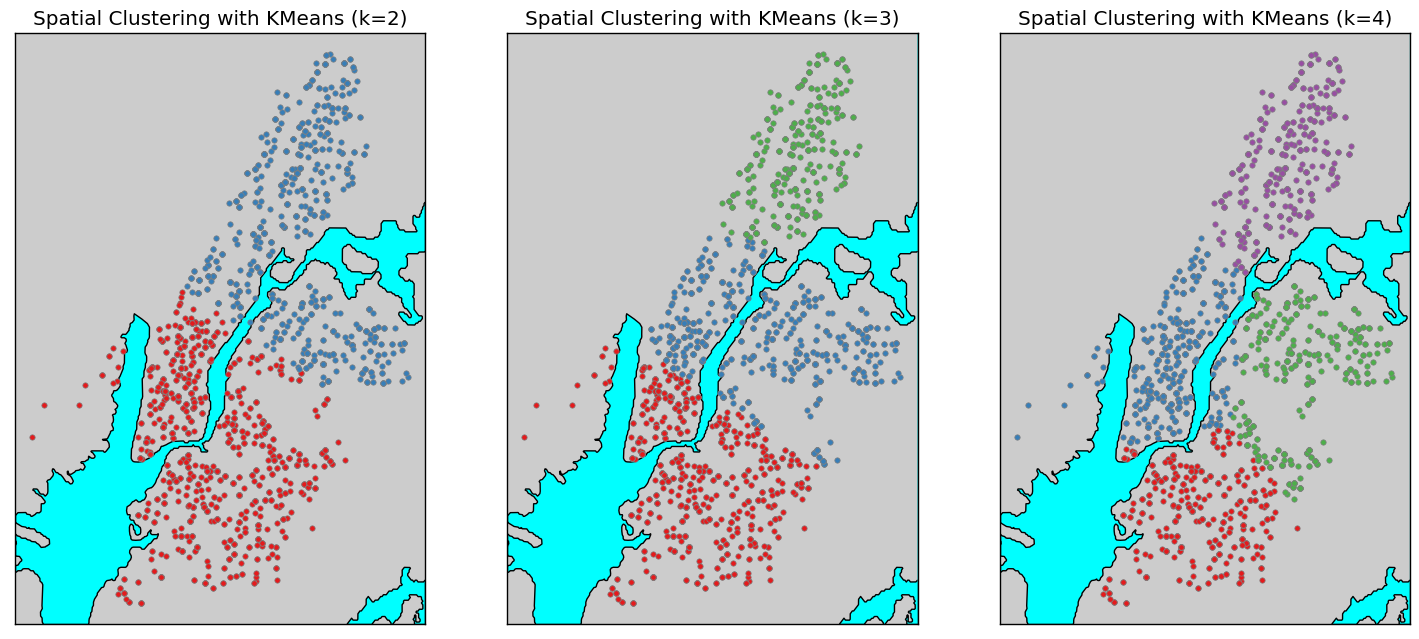

In [442]:
k = [2, 3, 4]
n = len(k)
plt.subplots(nrows=1, ncols=3, figsize=(18,15))
 

for i in range(n):
    est = kmean[k[i]-1]
    dfStInf['cluster'] = est.predict(X).tolist()
    ax = plt.subplot(1, 3, i+1)
    ax.set_title("Spatial Clustering with KMeans (k={})".format(k[i]))
    plot_stations_map(ax, dfStInf)
plt.savefig('/Users/avaisman/tmp/PythonNotebooks/Figs/kmeans.svg', format="svg",bbox_inches ="tight")

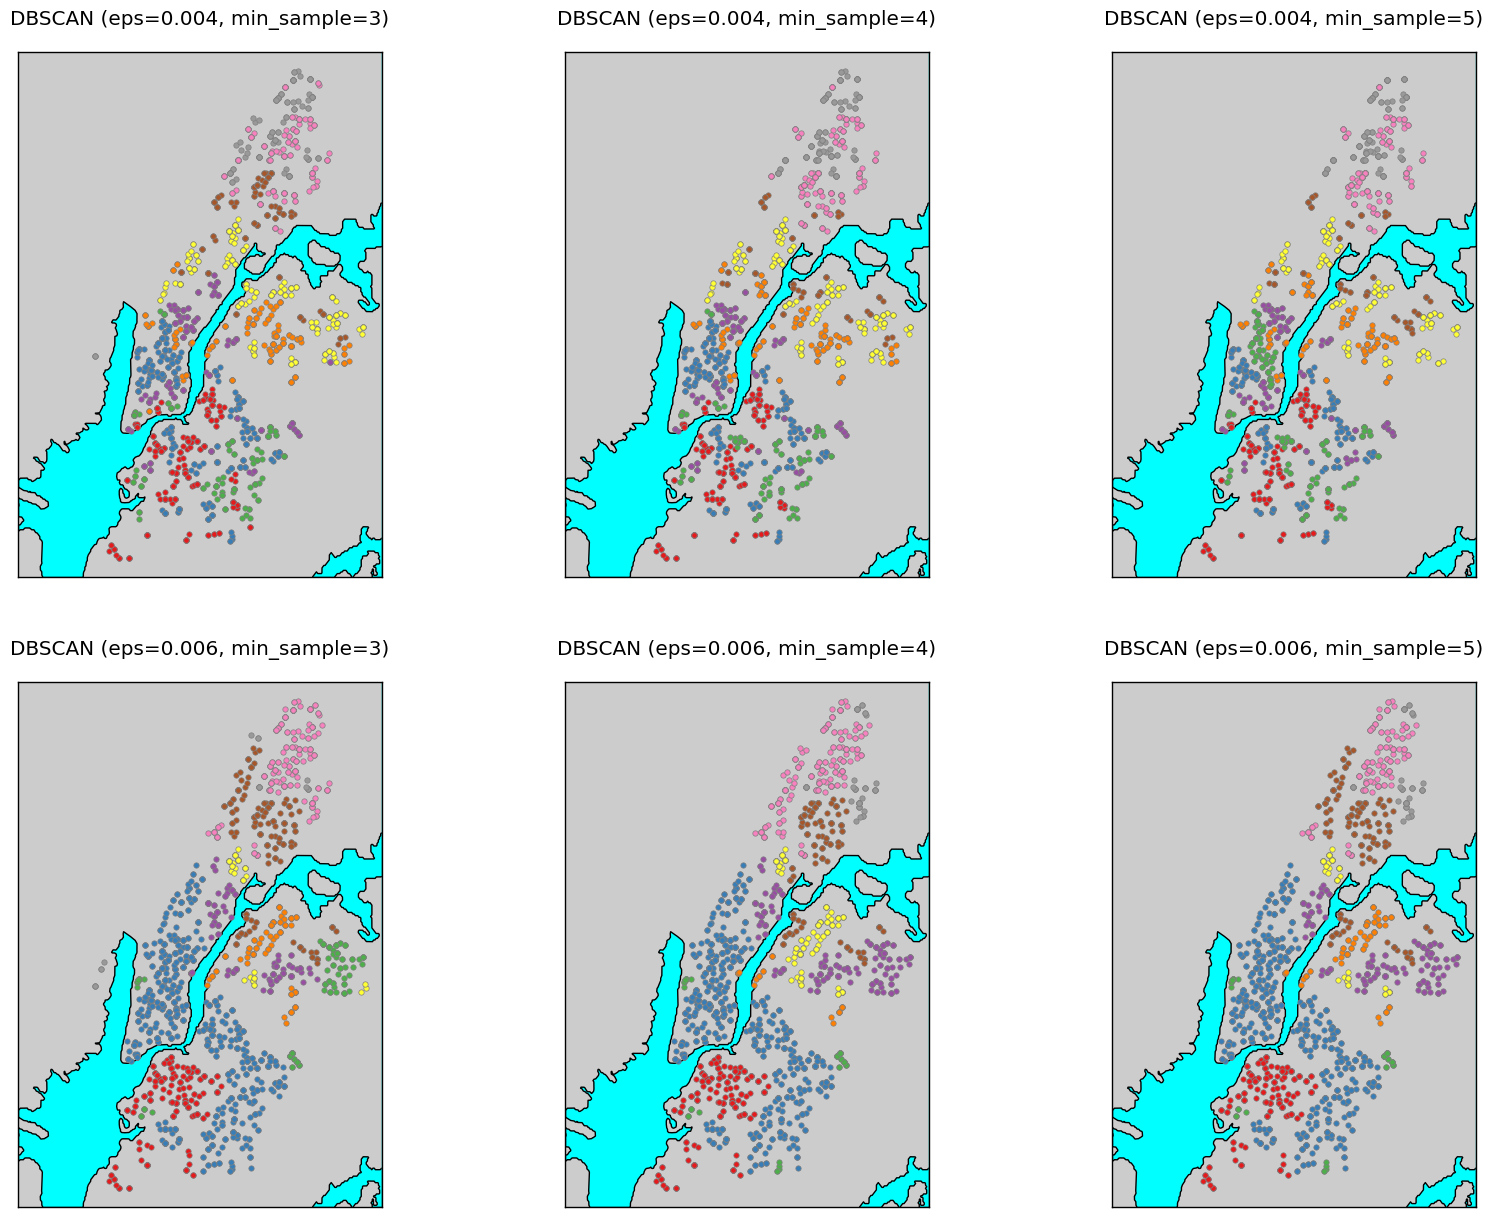

In [448]:
eps = [0.004, 0.006]   # unit: latitude/longitude
min_sample = [3, 4, 5]
n1, n2 = len(eps), len(min_sample)
plt.subplots(nrows=n1, ncols=n2, figsize=(20, 15))

for i in range(n1):
    for j in range(n2):
        est = DBSCAN(eps=eps[i], min_samples=min_sample[j], metric="euclidean").fit(X)
        dfStInf['cluster'] = est.labels_.tolist()

        ax = plt.subplot(n1, n2, n2*i+j+1)
        ax.set_title("DBSCAN (eps={}, min_sample={})".format(eps[i], min_sample[j]),pad=20)
        plot_stations_map(ax, dfStInf)
plt.savefig('/Users/avaisman/tmp/PythonNotebooks/Figs/dbscan.svg', format="svg",bbox_inches ="tight")

In [452]:
def greatCircleDistance(x, y):
    lat1, lon1 = x[0], x[1]
    lat2, lon2 = y[0], y[1]
    return geodesic((lat1, lon1), (lat2, lon2)).meters

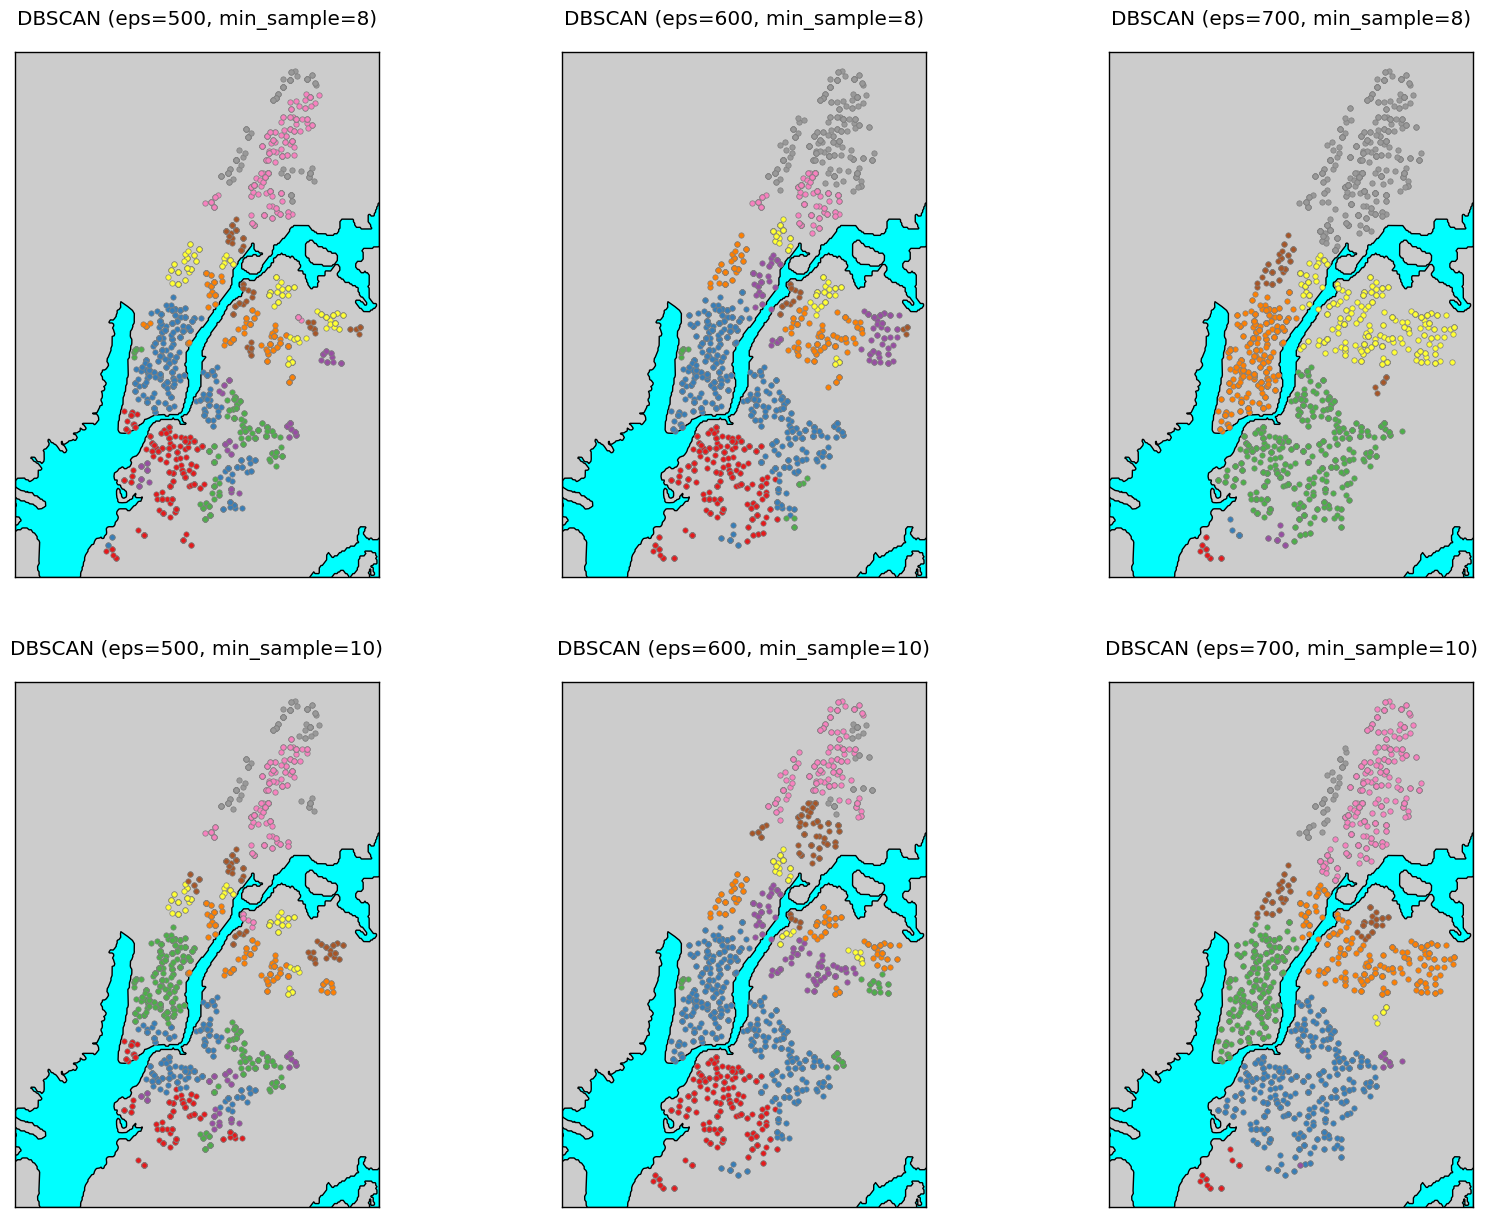

In [454]:
eps = [500, 600, 700]    # unit: meter
min_sample = [8, 10]
n1, n2 = len(eps), len(min_sample)
plt.subplots(nrows=n2, ncols=n1, figsize=(20, 15))

for j in range(n2):
    for i in range(n1):
        est = DBSCAN(eps=eps[i], min_samples=min_sample[j], metric=greatCircleDistance).fit(X)
        dfStInf['cluster'] = est.labels_.tolist()

        ax = plt.subplot(n2, n1, n1*j+i+1)
        ax.set_title("DBSCAN (eps={}, min_sample={})".format(eps[i], min_sample[j]), pad=20)
        plot_stations_map(ax, dfStInf)
plt.savefig('/Users/avaisman/tmp/PythonNotebooks/Figs/dbscan-gc.svg', format="svg",bbox_inches ="tight")

In [111]:
 TEMPORAL CLUSTERING

In [693]:
X = df_temp.drop(["station_id"], axis=1).values
len(X)

2143

In [698]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        #plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.title(' ')
        plt.xlabel('Sample Index', fontsize=28,labelpad=12)
        plt.ylabel('Distance', fontsize=28,labelpad=12)
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center',size=16)
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [699]:
def plot_dendrogram(Z, p, d):
    plt.figure(figsize=(25, 10))
    #plt.title('Hierarchical Clustering Dendrogram', pad=20)
    plt.title(' ', )
    plt.xlabel('Sample Index',fontsize=28, labelpad=12)
    plt.ylabel('distance',fontsize=28,labelpad=12)
    fancy_dendrogram(
        Z,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=16.,  # font size for the x axis labels
        show_contracted=True,
        truncate_mode='lastp',  # show only the last p merged clusters
        p=p,  # show only the last p merged clusters
        annotate_above=d,  # useful in small plots so annotations don't overlap
    )
    plt.savefig('/Users/avaisman/Dropbox/MobilityBook/Figs/MobilityAnalysis/dendogram.svg', format="svg",bbox_inches ="tight")
    plt.show()

In [697]:
df_All.columns

Index(['station_id', 'station_name', 'station_lat', 'station_lng', 'in_count',
       'in_count', 'in_count', 'in_count', 'in_count', 'in_count',
       ...
       'out_count', 'out_count', 'out_count', 'out_count', 'out_count',
       'out_count', 'out_count', 'out_count', 'out_count', 'out_count'],
      dtype='object', length=676)

In [566]:
def plot_flow_lines(ax, stns):
    clist = stns['cluster'].unique()
    if -1 in clist:
        clist.remove(-1)
    k = len(clist)
    colors = iter(cm.Set1(np.linspace(0, 1, 8)))
    for i in range(k):
        color = next(colors)
        df = stns.loc[stns['cluster'] == clist[i]]
        in_cols = list(filter(lambda x: 'in_count' in x, df_All.columns))
        out_cols = list(filter(lambda x: 'out_count' in x, df_All.columns))
        timeline = list(map(lambda x: x[1], in_cols))
        flows = df[in_cols].values + df[out_cols].values
        ax.plot(timeline, np.mean(flows, axis=0), color=color)
        #ax.plot(timeline, np.mean(flows, axis=0), color=color, alpha=0.3, linewidth=np.mean(np.std(flows, axis=0)))


In [700]:
def plot_agglomerative_clustering_result(df_All, Z, dist, affinity):
    n = len(dist)
    plt.subplots(nrows=n, ncols=2, figsize=(15, 12))

    for i in range(n):
        df_All['cluster'] = fcluster(Z, dist[i], 'distance')
        #k = len(df_all['cluster'].unique())
        #print("[affinity='{}', cut-off distance={}]\nNumber of clusters: {}".format(affinity, dist[i], k))

        ax = plt.subplot(n, 2, 2*i+1)
        ax.set_title("Agglomerative Clustering (Linkage='{}', distance>{})".format(affinity, dist[i]))
        plot_stations_map(ax, df_All)

        ax = plt.subplot(n, 2, 2*i+2)
        ax.set_title("Average Flow for each cluster (Linkage='{}', distance>{})".format(affinity, dist[i]))
        plot_flow_lines(ax, df_All)

In [703]:
def plot_agglomerative_clustering_result(df_All, Z, dist, affinity):
# WITHOUT FLOW LINES
    n = len(dist)
    plt.subplots(nrows=n, ncols=1, figsize=(10, 10))

    for i in range(n):
        df_All['cluster'] = fcluster(Z, dist[i], 'distance')
        #k = len(df_all['cluster'].unique())
        #print("[affinity='{}', cut-off distance={}]\nNumber of clusters: {}".format(affinity, dist[i], k))

        ax = plt.subplot(n, 1, 1*i+1)
        ax.set_title("Agglomerative Clustering (Linkage='{}', distance>{})".format(affinity, dist[i]))
        plot_stations_map(ax, df_All)
        plt.savefig('/Users/avaisman/Dropbox/MobilityBook/Figs/MobilityAnalysis/ward1.pdf', format="pdf",bbox_inches ="tight",dpi=250)
        #ax = plt.subplot(n, 1, 1*i+1)
        #ax.set_title("Average Flow for each cluster (Linkage='{}', distance>{})".format(affinity, dist[i]))
        #plot_flow_lines(ax, df_All)

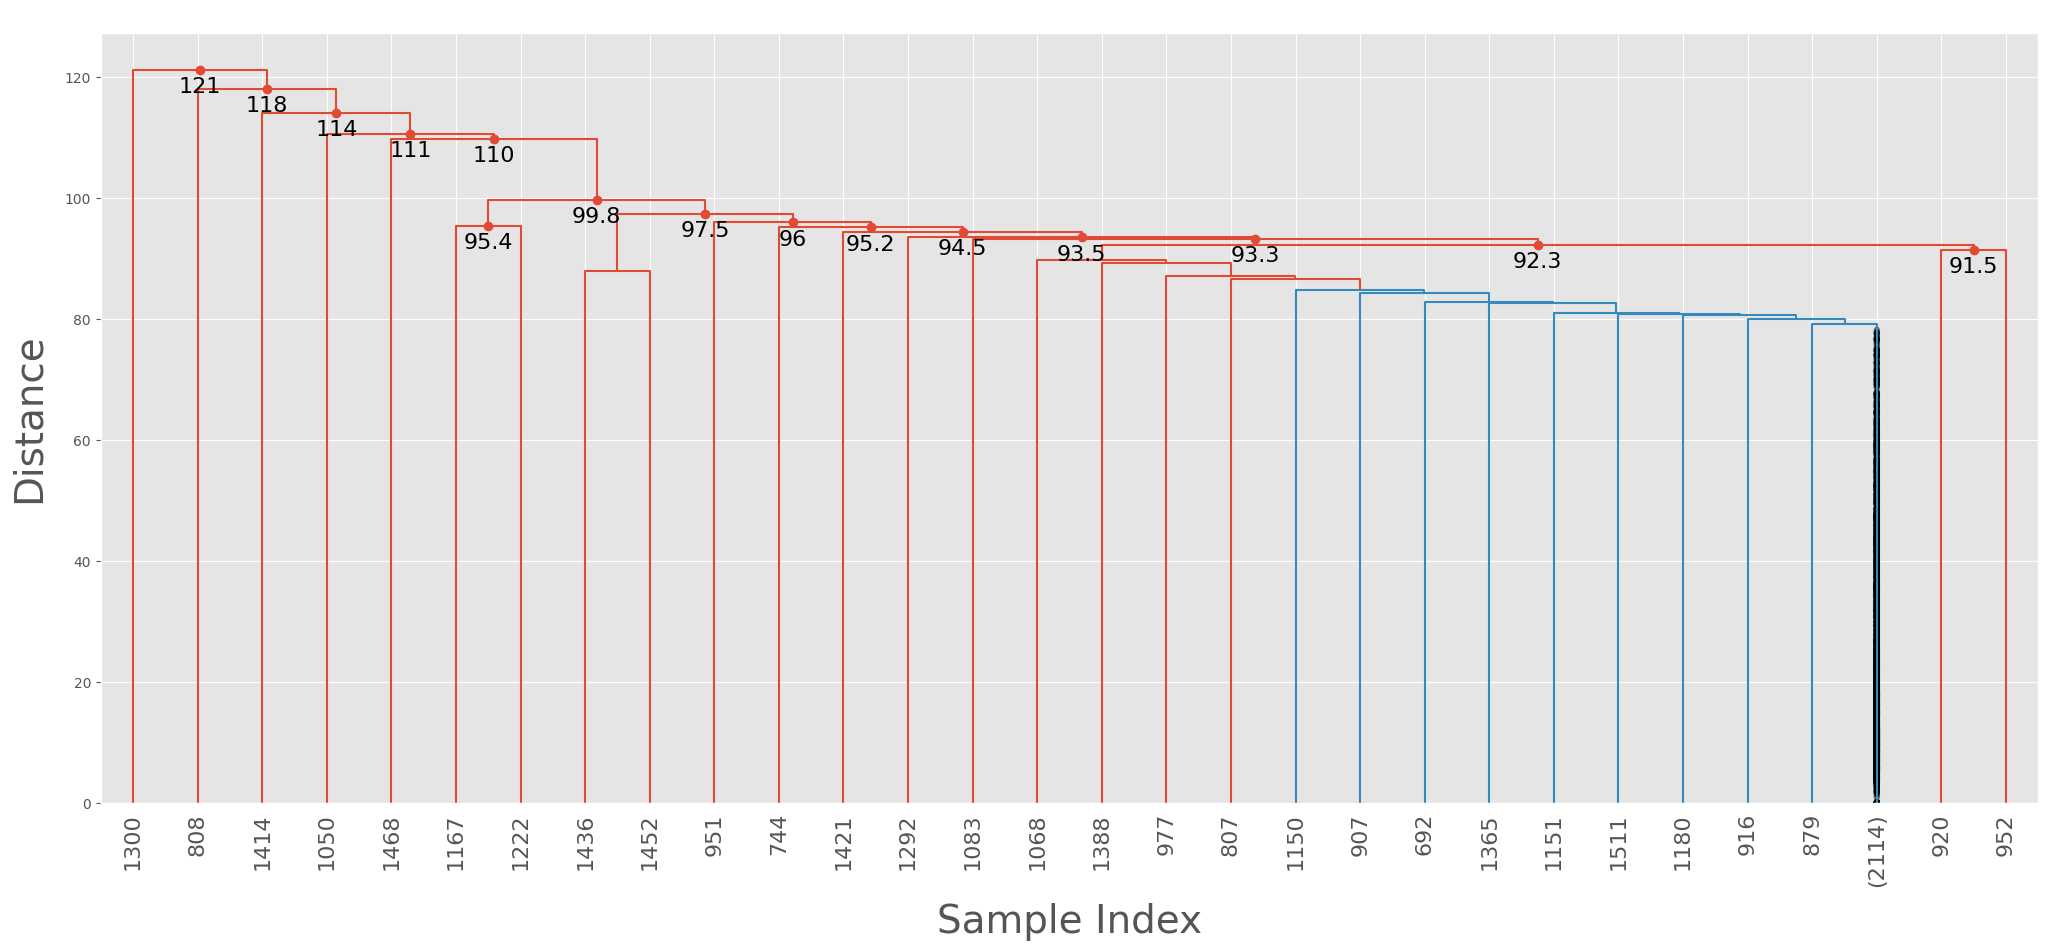

In [564]:
affinity = 'single'
Z = linkage(X, affinity)
plot_dendrogram(Z, 
                30,   
                90)

In [597]:
dist = [110, 80]
#plot_agglomerative_clustering_result(df_All, Z, dist, affinity)

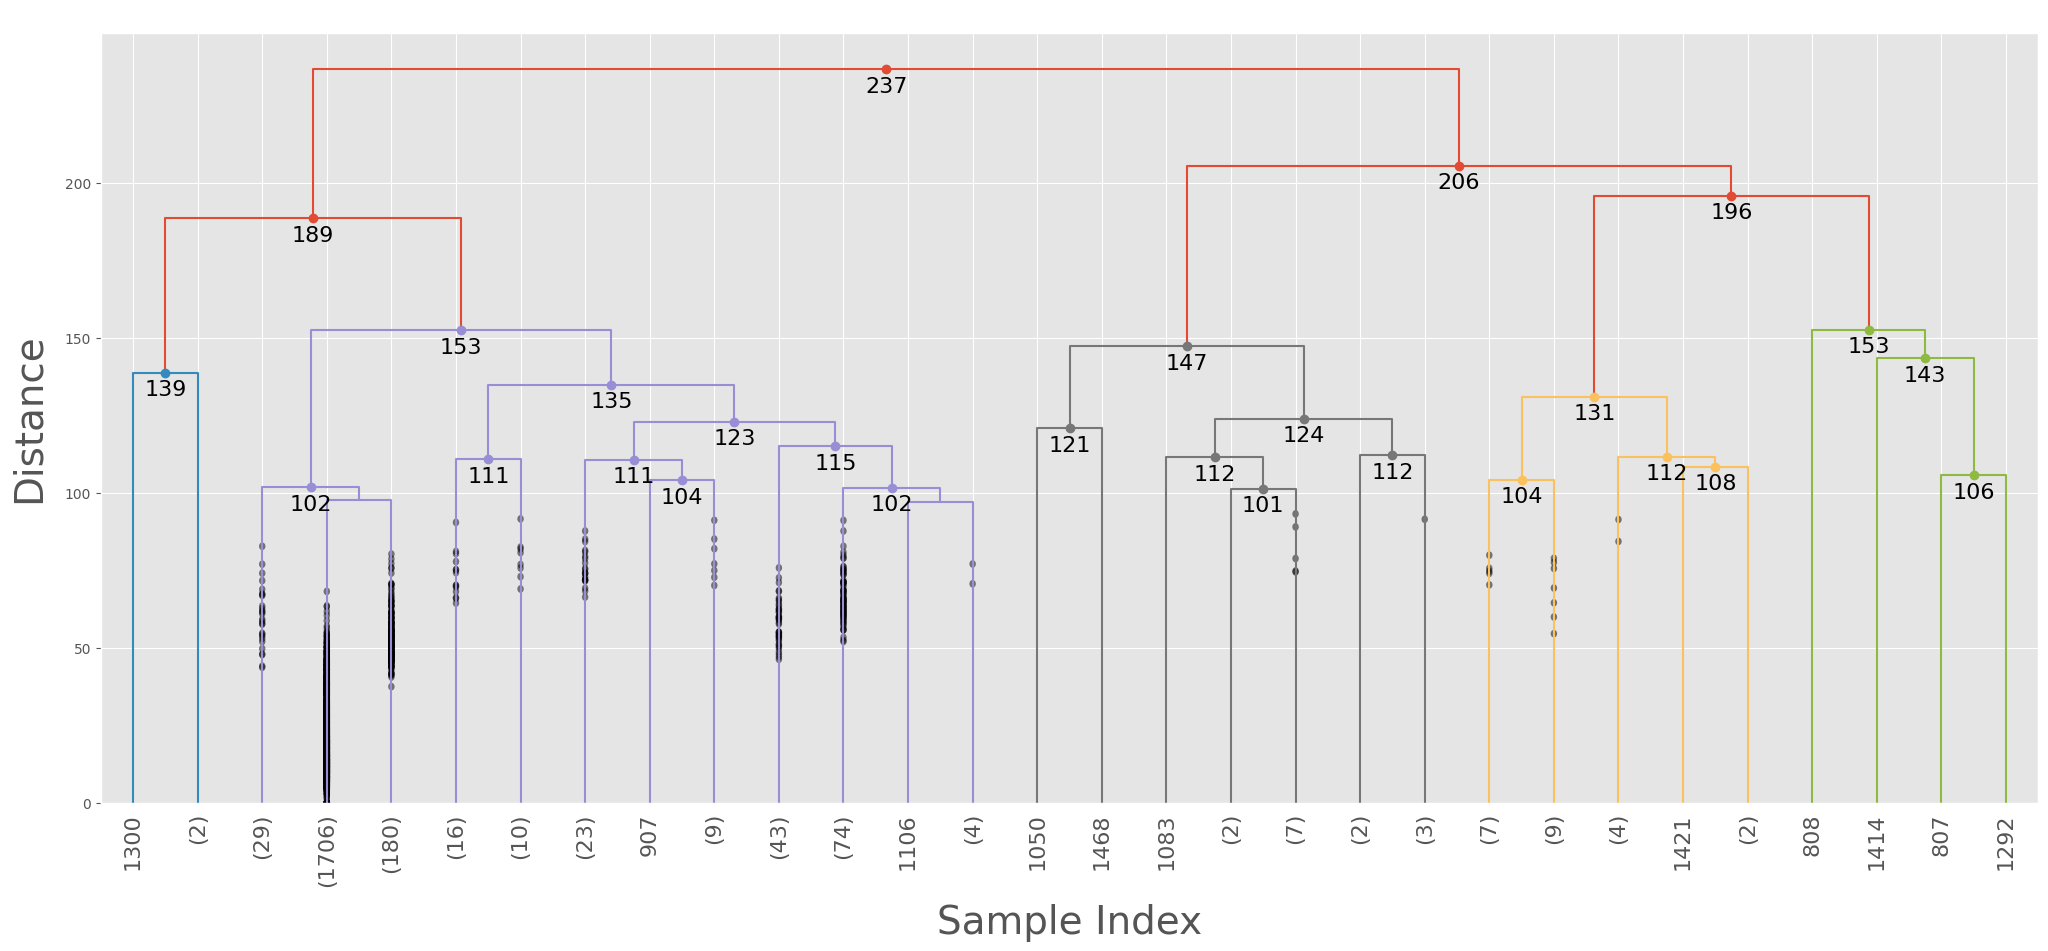

In [526]:
affinity = 'complete'
Z = linkage(X, affinity)
plot_dendrogram(Z, 
                30,   
                100)

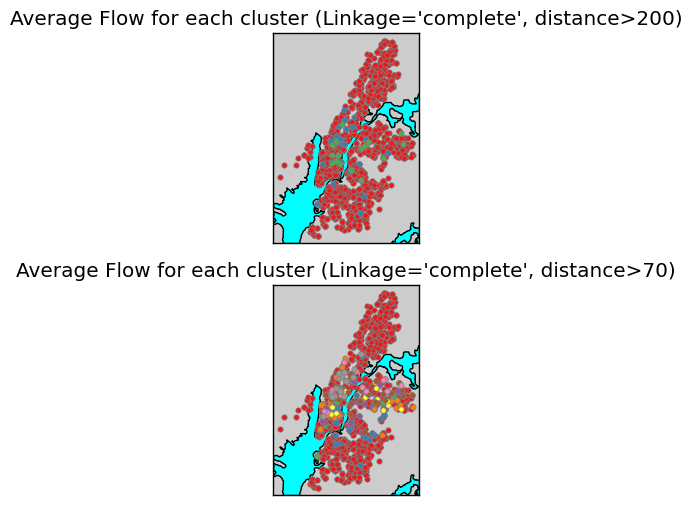

In [528]:
dist = [200, 70]
plot_agglomerative_clustering_result(df_All, Z, dist, affinity)

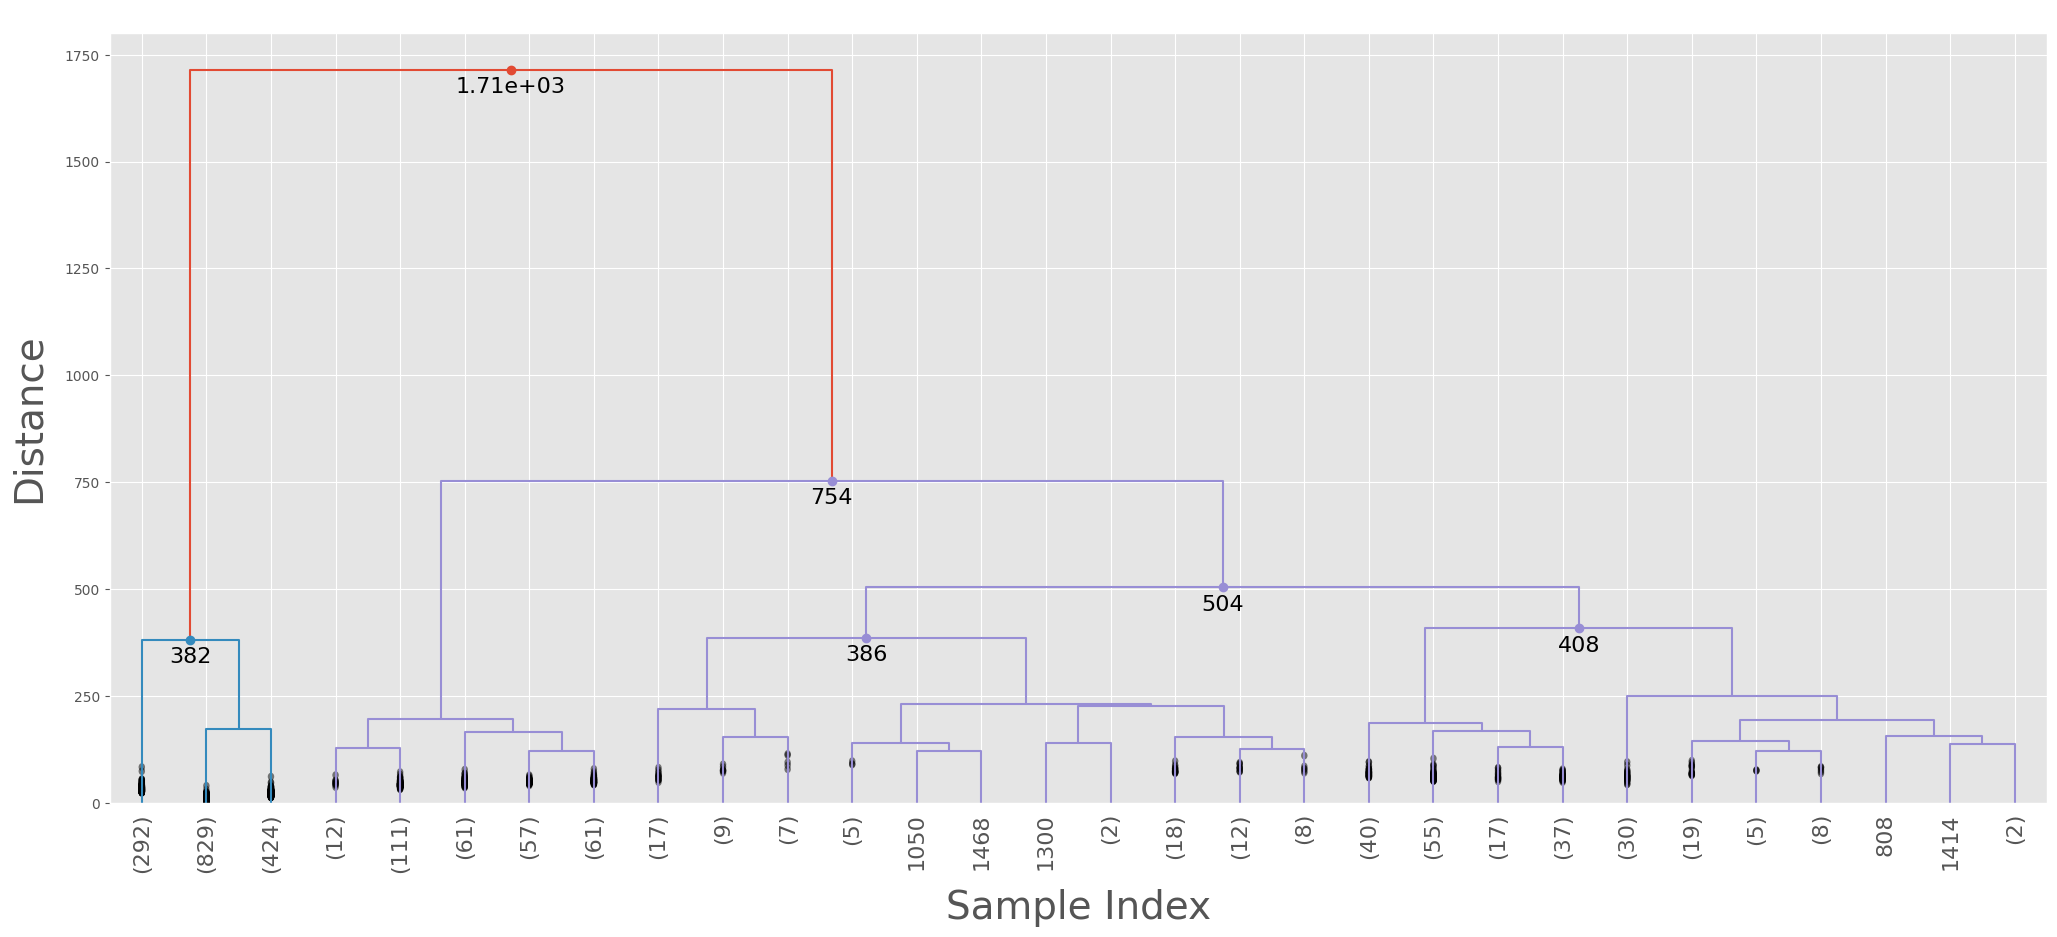

In [701]:
affinity = 'ward'
Z = linkage(X, affinity)
plot_dendrogram(Z, 
                30,    # only show the last 30 merges
                300)   # only annotates distance above 300

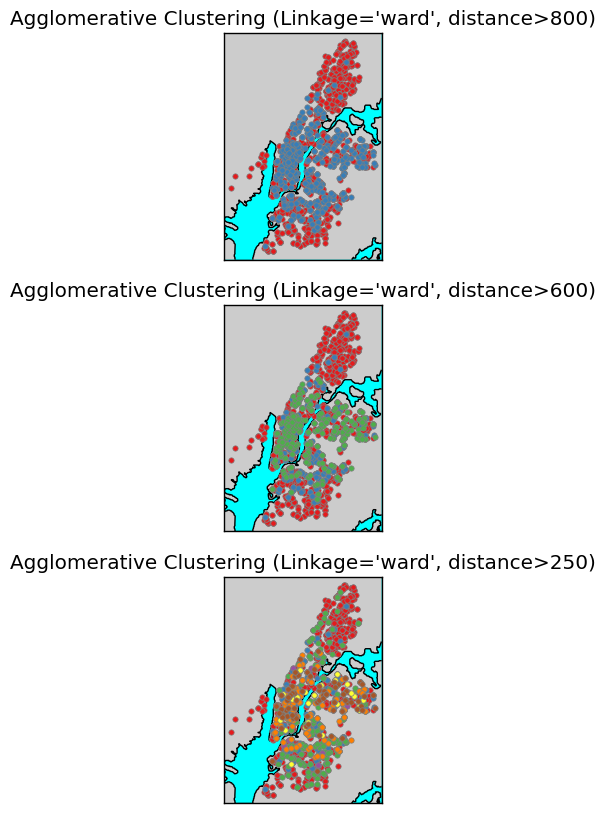

In [704]:
dist = [800, 600, 250]
plot_agglomerative_clustering_result(df_All, Z, dist, affinity)

In [714]:
df = df_All.loc[df_All['cluster'] == 1]
df

,station_id,station_name,station_lat,station_lng,in_count,in_count,in_count,in_count,in_count,in_count,...,out_count,out_count,out_count,out_count,out_count,out_count,out_count,out_count,out_count,cluster
105,3382.04,Troy Ave & Linden Blvd,40.662880,-73.940190,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
121,3454.01,Clarkson Ave & Troy Ave,40.692216,-73.984284,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
131,3495.08,Lenox Rd & E 43 St,40.655770,-73.943200,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
141,3535.03,Winthrop St & Albany Ave,40.661550,-73.939740,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
149,3576.1,Rutland Rd & Brooklyn Ave,40.661240,-73.931640,0.0,0.0,0.0,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1913,8226.06,Broadway & W 168 St,40.832164,-73.949702,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1
1914,8226.07,W 168 St & Ft Washington Ave,40.872412,-73.912807,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,4.0,1
1926,8262.07,W 171 St & St Nicholas Ave,40.847305,-73.933291,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1
1954,8336.02,Wadsworth Ave & W 179 St,40.840960,-73.879230,1.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,1.0,2.0,1.0,0.0,1.0,1.0,1.0,1


In [ ]:
Agglomerative Clustering with PCA 

In [717]:
n_components = 30
pca = PCA(n_components=n_components)
pca.fit(X)
X_pca = pca.transform(X)
len(X_pca)

2143

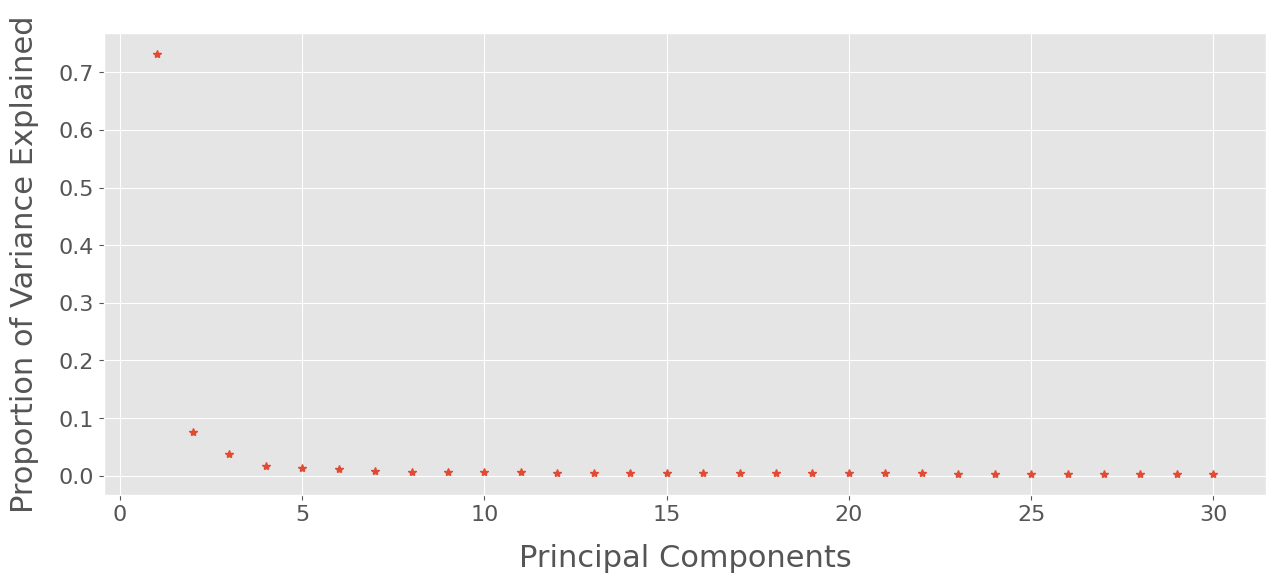

In [718]:
plt.subplots(nrows=1, ncols=2, figsize=(15,6))

#ax = plt.subplot(1, 2, 1)
#ax.plot(range(1, n_components+1), 
#        '*')
#plt.grid(True)
#plt.xlabel('Principal Components',fontsize=22, labelpad=14)
#plt.ylabel('Singular Values',fontsize=22,labelpad=14)
#plt.yticks(fontsize=16)
#plt.xticks(fontsize=16)
#plt.title(' ')
 
ax = plt.subplot(1, 1, 1)
ax.plot(range(1, n_components+1), 
        np.power(pca.singular_values_, 2)/sum(np.power(pca.singular_values_, 2)), 
        '*' )
plt.grid(True)
plt.xlabel('Principal Components',fontsize=22,labelpad=14)
plt.ylabel('Proportion of Variance Explained',fontsize=22,labelpad=14)
plt.title(' ')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.savefig('/Users/avaisman/Dropbox/MobilityBook/Figs/MobilityAnalysis/pcavar.svg', format="svg", dpi=250, bbox_inches ="tight")
plt.show()


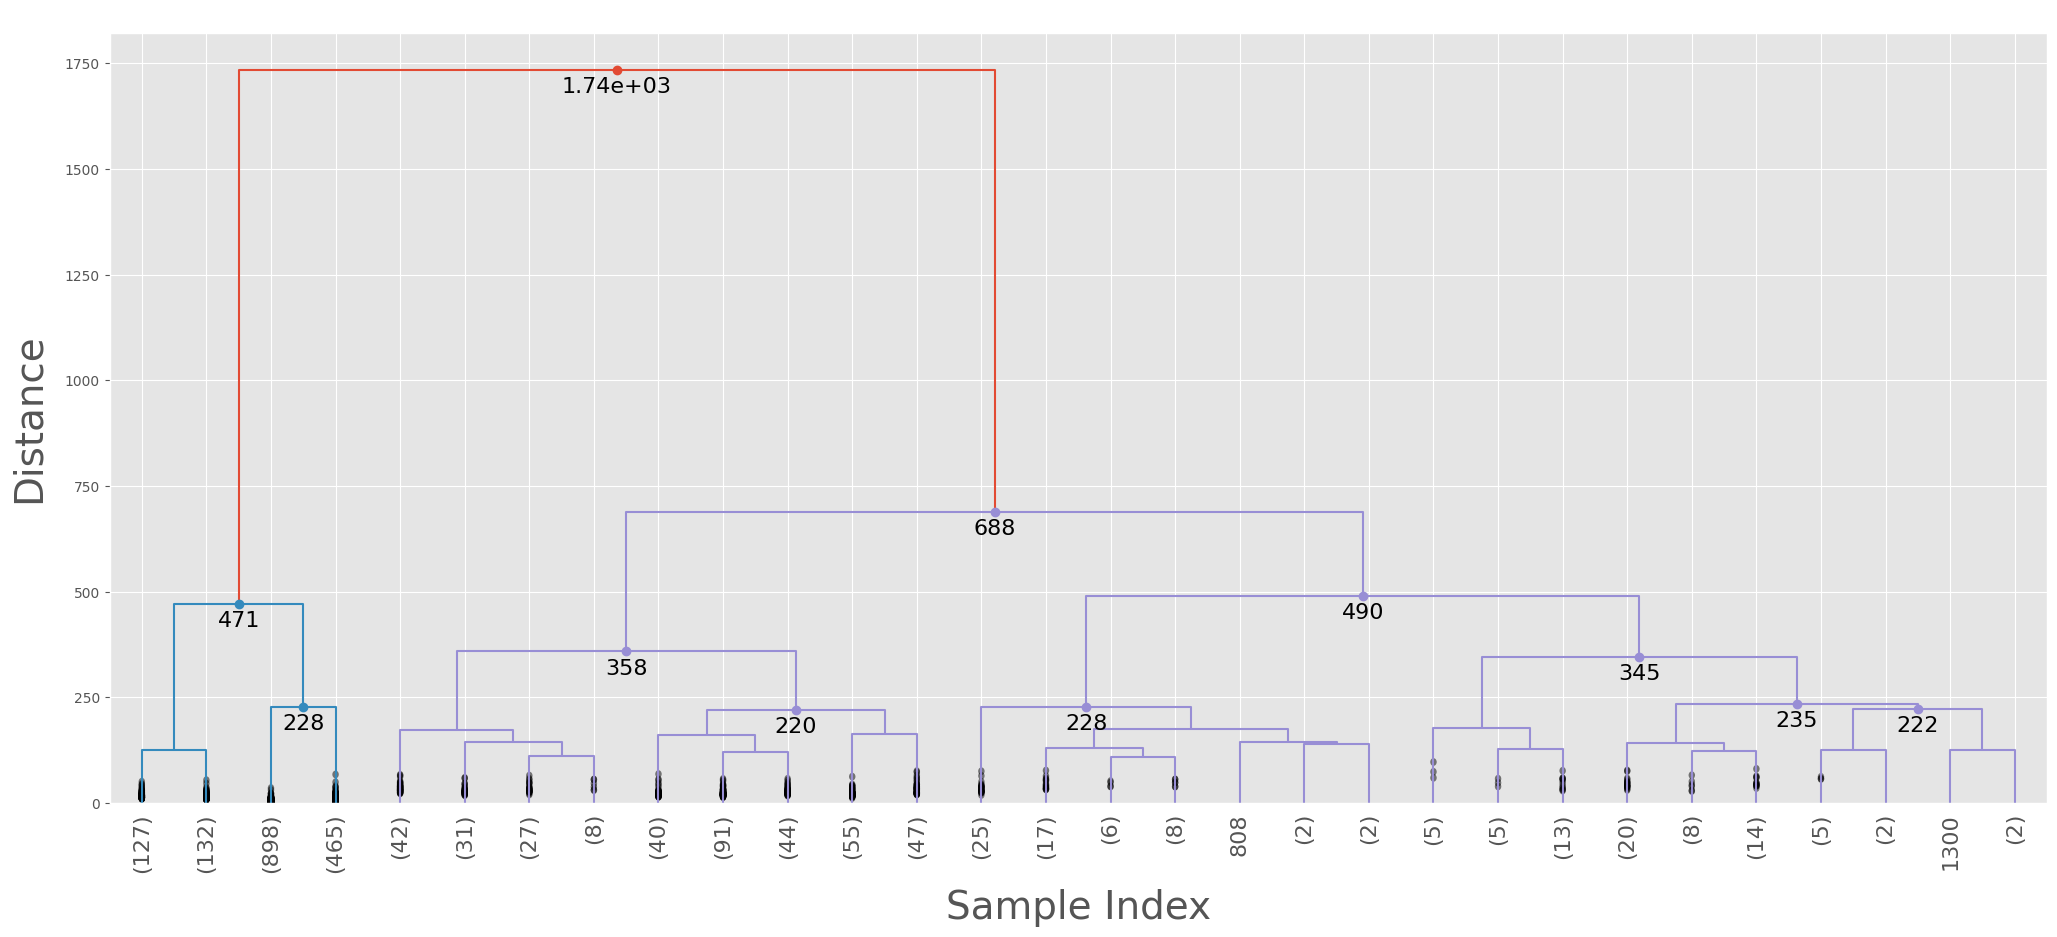

In [720]:
affinity = 'ward'
Z = linkage(X_pca, affinity)
plot_dendrogram(Z, 
                30,    # only show the last 30 merges
                200)

In [721]:
def plot_agglomerative_PCA_clustering_result(df_all, Z, dist, affinity, n_components):
    n = len(dist)
    plt.subplots(nrows=n, ncols=1, figsize=(10, 10))

    for i in range(n):
        df_All['cluster'] = fcluster(Z, dist[i], 'distance')

        ax = plt.subplot(n, 1, 1*i+1)
        ax.set_title("Agglomerative Clustering (n_components={}, distance>{})".format(n_components, dist[i]))
        plot_stations_map(ax, df_All)
        plt.savefig('/Users/avaisman/Dropbox/MobilityBook/Figs/MobilityAnalysis/pcaWard.pdf', format="pdf",bbox_inches ="tight",dpi=250)

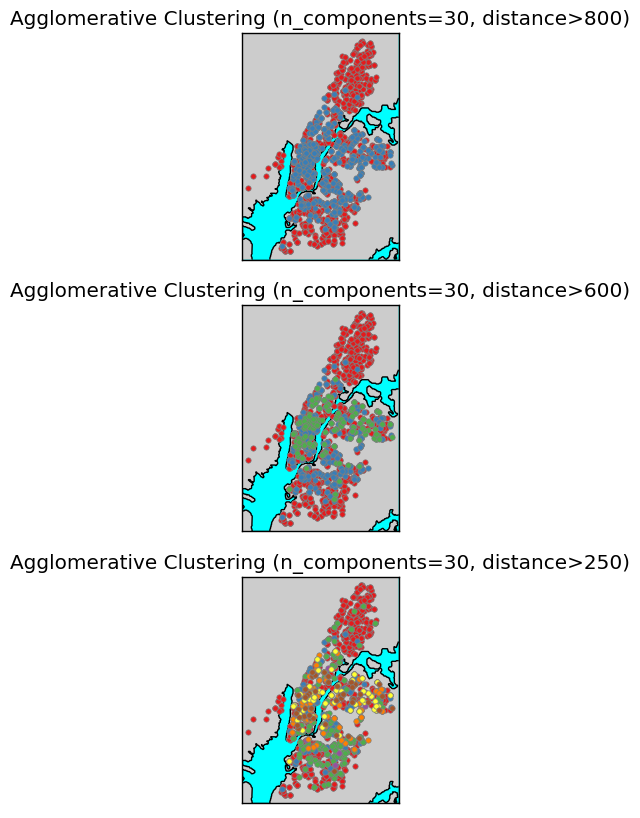

In [723]:
dist = [800, 600, 250]
plot_agglomerative_PCA_clustering_result(df_all, Z, dist, affinity, n_components)

In [724]:
df_All

,station_id,station_name,station_lat,station_lng,in_count,in_count,in_count,in_count,in_count,in_count,...,out_count,out_count,out_count,out_count,out_count,out_count,out_count,out_count,out_count,cluster
0,2733.03,67 St & Erik Pl,40.635560,-74.012980,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,2782.02,5 Ave & 67 St,40.635679,-74.020005,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,2821.05,7 Ave & 62 St,40.647379,-74.000911,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,2832.03,4 Ave & Shore Road Dr,40.679279,-73.981540,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,2861.02,57 St & 7 Ave,40.675833,-74.014726,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2138,JC105,Hoboken Ave at Monmouth St,40.750604,-74.024020,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2139,JC109,Bergen Ave & Sip Ave,40.725726,-74.071959,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2140,SYS016,Morgan Bike Mechanics,40.701080,-73.917900,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2141,SYS033,Pier 40 X2,40.729170,-73.998102,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [726]:
df = df_All.loc[df_All['cluster'] == 7]
df

,station_id,station_name,station_lat,station_lng,in_count,in_count,in_count,in_count,in_count,in_count,...,out_count,out_count,out_count,out_count,out_count,out_count,out_count,out_count,out_count,cluster
738,5294.04,Henry St & Grand St,40.739126,-73.979738,0.0,1.0,1.0,0.0,0.0,0.0,...,11.0,4.0,3.0,0.0,4.0,3.0,3.0,0.0,0.0,7
739,5297.02,Vesey Pl & River Terrace,40.720253,-73.957082,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,5.0,2.0,3.0,2.0,1.0,1.0,1.0,0.0,7
740,5300.05,Metropolitan Ave & Meeker Ave,40.664810,-73.942690,0.0,1.0,0.0,0.0,0.0,0.0,...,3.0,4.0,5.0,1.0,6.0,0.0,1.0,2.0,0.0,7
766,5365.02,Columbia St & Rivington St,40.729515,-73.990753,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,3.0,0.0,4.0,0.0,1.0,0.0,7
769,5371.07,Frost St & Meeker Ave,40.705614,-73.921530,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,2.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,7
770,5374.01,Norfolk St & Broome St,40.737815,-73.999947,0.0,1.0,1.0,0.0,0.0,0.0,...,6.0,0.0,2.0,8.0,7.0,7.0,2.0,3.0,5.0,7
818,5489.03,Kent Ave & N 7 St,40.716021,-73.999744,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,2.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,7
846,5558.04,Wythe Ave & N 13 St,40.754730,-73.933670,0.0,0.0,1.0,0.0,0.0,0.0,...,4.0,3.0,2.0,0.0,1.0,0.0,1.0,2.0,1.0,7
874,5626.13,St Marks Pl & 1 Ave,40.727408,-73.981420,2.0,1.0,0.0,0.0,0.0,0.0,...,2.0,1.0,6.0,5.0,3.0,2.0,1.0,1.0,2.0,7
886,5669.10,St Marks Pl & 2 Ave,40.737815,-73.999947,3.0,0.0,0.0,0.0,0.0,0.0,...,4.0,4.0,4.0,8.0,3.0,1.0,3.0,3.0,1.0,7


In [ ]:
SPATIOTEMPORAL K-MEANS

In [728]:
X=df_All.drop(["station_id", "station_name"], axis=1).values

In [729]:
X

array([[ 40.63556   , -74.01298   ,   0.        , ...,   0.        ,
          0.        ,   2.        ],
       [ 40.635679  , -74.020005  ,   0.        , ...,   0.        ,
          0.        ,   2.        ],
       [ 40.647379  , -74.000911  ,   0.        , ...,   0.        ,
          0.        ,   2.        ],
       ...,
       [ 40.70108   , -73.9179    ,   0.        , ...,   0.        ,
          0.        ,   2.        ],
       [ 40.72917025, -73.99810231,   0.        , ...,   0.        ,
          0.        ,   2.        ],
       [ 40.700119  , -73.9862    ,   0.        , ...,   0.        ,
          0.        ,   2.        ]])

In [731]:
def combine_spatial_temporal(X, n_temporal):
    pca = PCA(n_components=n_temporal)
    X_pca = pca.fit_transform(X[:, 2:])
    X = np.hstack((X[:, :2], X_pca))
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)
    return X_std

In [732]:
def plot_spatial_temporal_clustering_result(kmean, n_components, k, Xs, df_all):
    n = len(n_components)
    plt.subplots(nrows=n, ncols=1, figsize=(14,14))

    for i in range(n):
        est = kmean[i]
        df_all['cluster'] = est.predict(Xs[i]).tolist()

        ax = plt.subplot(n, 1, 1*i+1)
        ax.set_title("Spatial-Temporal Clustering with KMeans (#temporal features={}, k={})".format(n_components[i], k))
        plot_stations_map(ax, df_all)
        plt.savefig('/Users/avaisman/Dropbox/MobilityBook/Figs/MobilityAnalysis/spatiotempkmeans.pdf', format="pdf",bbox_inches ="tight",dpi=250)
        #ax = plt.subplot(n, 1, 1*i+1)
        #ax.set_title("Average Flow for each cluster (#temporal features={}, k={})".format(n_components[i], k))
        #plot_flow_lines(ax, df_all)

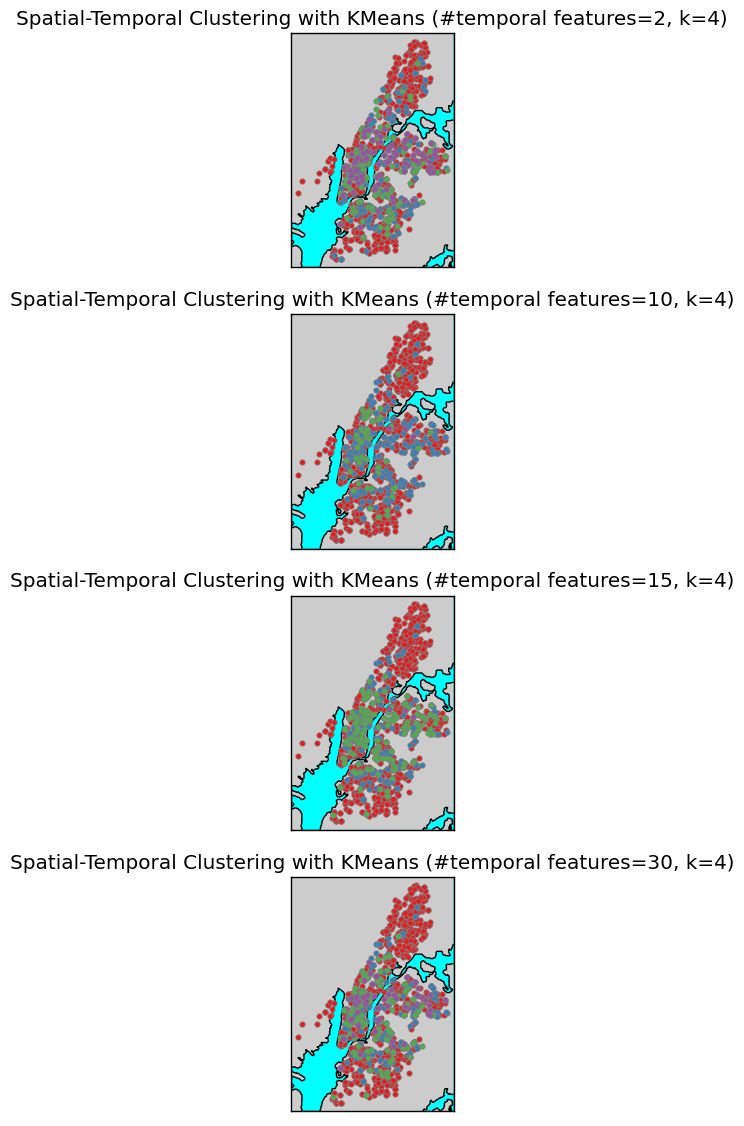

In [631]:
k = 4
n_components = [2, 10, 15, 30]
Xs = [combine_spatial_temporal(X, i) for i in n_components]
kmean = [KMeans(n_clusters=k).fit(data) for data in Xs]
plot_spatial_temporal_clustering_result(kmean, n_components, k, Xs, df_All)